In [18]:
import pandas as pd
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data_frame = pd.read_csv("E:/environment/git/AI/ML/Data/Loan Data of Dreaming Housing Finance/train.csv")

In [6]:
data_frame.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [8]:
data_frame.describe() #get summeries of variables

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


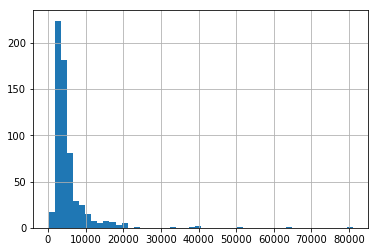

In [17]:
data_frame['ApplicantIncome'].hist(bins=50) #view distribution of a variable

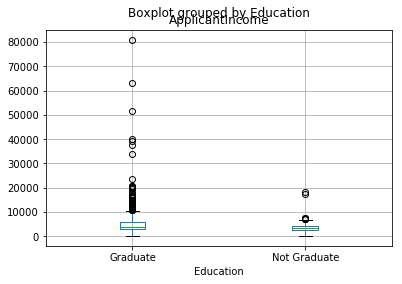

In [19]:
data_frame.boxplot(column = 'ApplicantIncome', by='Education')

In [22]:
temp1 = data_frame['Credit_History'].value_counts(ascending=True)
temp2 = data_frame.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print ('Frequency Table for Credit History:' )
print (temp1)

print ('\nProbility of getting loan for each Credit History class:' )
print (temp2)

Frequency Table for Credit History:
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probility of getting loan for each Credit History class:
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


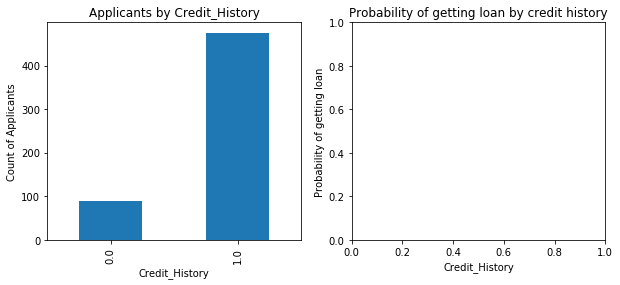

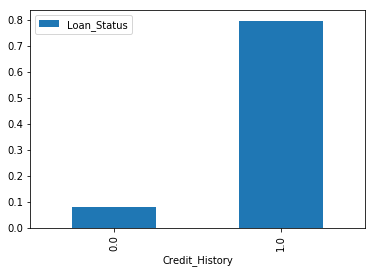

In [34]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')

ax2 = fig.add_subplot(122)
ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title("Probability of getting loan by credit history")
temp2.plot(kind = 'bar')

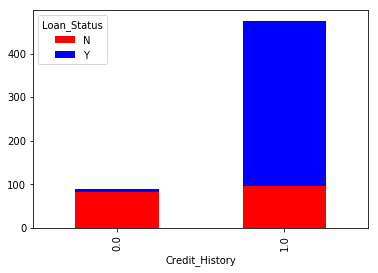

In [35]:
temp3 = pd.crosstab(data_frame['Credit_History'], data_frame['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

In [36]:
 data_frame.apply(lambda x: sum(x.isnull()),axis=0)  #check missing value 
#=> there are some null value in some columns that need to be replaced

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [44]:
data_frame['Self_Employed'].value_counts()
#replace null values of Self_employed to No (since 500No >> 82Yes)
data_frame['Self_Employed'].fillna('No',inplace = True)

In [45]:
 data_frame['LoanAmount'].fillna(data_frame['LoanAmount'].mean(), inplace=True)

In [47]:
table = data_frame.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]

In [48]:
table


Education,Graduate,Not Graduate
Self_Employed,,
No,131.0,115.0
Yes,152.0,130.0


In [49]:
data_frame['LoanAmount'] = np.log(data_frame['LoanAmount'])

In [52]:
data_frame['TotalIncome'] = data_frame['ApplicantIncome'] + data_frame['CoapplicantIncome']
data_frame['TotalIncome'] = np.log(data_frame['TotalIncome'])

In [67]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    data_frame[i] = le.fit_transform(data_frame[i])
data_frame.dtypes 

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
TotalIncome          float64
dtype: object

In [68]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

In [60]:
#Logistic Regression 
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['TotalIncome']
classification_model(model, data_frame,predictor_var,outcome_var)

Accuracy : 68.730%
Cross-Validation Score : 68.729%


In [72]:
model = DecisionTreeClassifier()
predictor_var = ['TotalIncome','Education']
classification_model(model, data_frame,predictor_var,outcome_var)

Accuracy : 96.580%
Cross-Validation Score : 58.143%
